# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

from astropy.constants import R_sun, L_sun, sigma_sb, G, M_earth, R_earth, R

import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

import tensorflow as tf

from geexhp import datasetup as dset
from geexhp import datavis as dvis
dvis.configure_matplotlib()

# Loading data and feature engineering

Since we're working with a large amount of data, we'll focus on visualizing just one of the 34 generated sets here. However, all the sets are expected to follow a similar pattern.

In [2]:
modern = dset.combine_parquet("../parallel/data1/", keyword="modern")
proterozoic = dset.combine_parquet("../parallel/data1/", keyword="proterozoic")
archean = dset.combine_parquet("../parallel/data1/", keyword="archean")

In [3]:
df = pd.concat([modern, proterozoic, archean], ignore_index=True)
df = dset.extract_abundances(df)
dfwithoutlimit = df.copy()

In [4]:
df["OBJECT-RADIUS-REL-EARTH"] = df["OBJECT-DIAMETER"].apply(lambda x: (x / (2 * R_earth.to("km").value)))

In [5]:
# This removes rows from the dataframe where any value in the "NOISE_" columns is greater than 3.
noise_columns = [col for col in df.columns if "NOISE_" in col]
mask = ~df[noise_columns].applymap(lambda x: any(value > 3 for value in x)).any(axis=1)
df = df[mask]

In [6]:
df["Earth_type"].value_counts()

archean        2047
proterozoic    2043
modern         2005
Name: Earth_type, dtype: int64

# Visualizing data

55
233
414


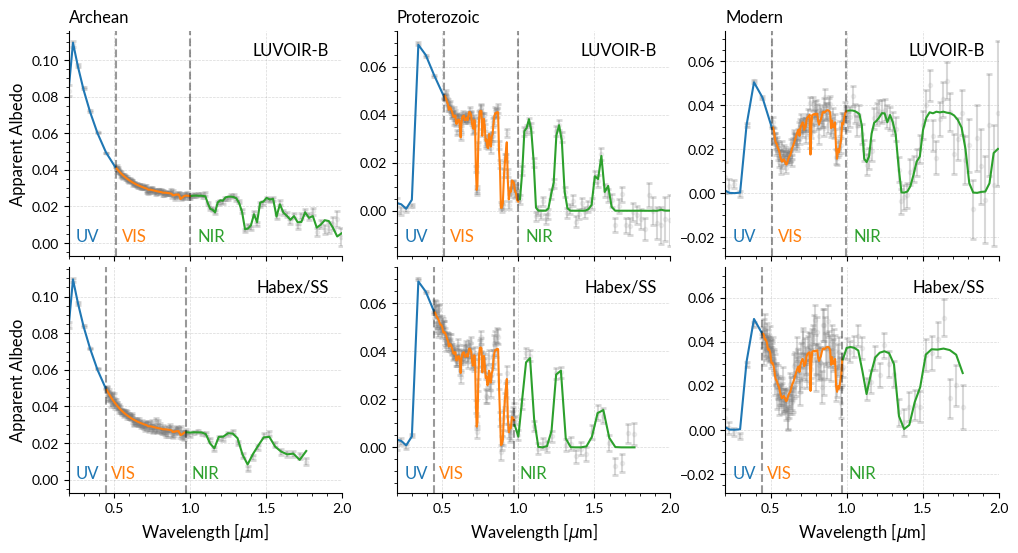

In [29]:
earth_types = ["archean", "proterozoic", "modern"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=True, sharey="col")

for j, et in enumerate(earth_types):
    subset = df[df["Earth_type"] == et]

    # This is just to avoid "ugly" plots :D
    mask = ~subset[noise_columns].applymap(lambda x: any(value > 0.05 for value in x)).any(axis=1)
    subset = subset[mask]
    rand_pos = np.random.randint(0, len(subset))

    print(rand_pos)
    
    dvis.plot_spectrum(subset, index=rand_pos, noise=True,
                        instruments=["B-UV", "B-Vis", "B-NIR"],
                        ax=axes[0, j], show_legend=False)
    
    dvis.plot_spectrum(subset, index=rand_pos, noise=True,
                        instruments=["SS-UV", "SS-Vis", "SS-NIR"],
                        ax=axes[1, j], show_legend=False)
    
    b_uv_end  = subset["WAVELENGTH_B-UV"].iloc[rand_pos][-1]
    b_vis_end = subset["WAVELENGTH_B-Vis"].iloc[rand_pos][-1]
    ss_uv_end  = subset["WAVELENGTH_SS-UV"].iloc[rand_pos][-1]
    ss_vis_end = subset["WAVELENGTH_SS-Vis"].iloc[rand_pos][-1]
    
    axes[0, j].axvline(b_uv_end,  color='k', linestyle='--', alpha=0.4)
    axes[0, j].axvline(b_vis_end, color='k', linestyle='--', alpha=0.4)

    axes[1, j].axvline(ss_uv_end,  color='k', linestyle='--', alpha=0.4)
    axes[1, j].axvline(ss_vis_end, color='k', linestyle='--', alpha=0.4)
    
    axes[0, j].text(0.07, 0.05, "UV",  color='tab:blue',   ha='center', va='bottom', transform=axes[0, j].transAxes)
    axes[0, j].text(0.24, 0.05, "VIS", color='tab:orange', ha='center', va='bottom', transform=axes[0, j].transAxes)
    axes[0, j].text(0.52,  0.05, "NIR", color='tab:green',  ha='center', va='bottom', transform=axes[0, j].transAxes)
    
    axes[1, j].text(0.07, 0.05, "UV",  color='tab:blue',   ha='center', va='bottom', transform=axes[1, j].transAxes)
    axes[1, j].text(0.2, 0.05, "VIS", color='tab:orange', ha='center', va='bottom', transform=axes[1, j].transAxes)
    axes[1, j].text(0.5, 0.05, "NIR", color='tab:green',  ha='center', va='bottom', transform=axes[1, j].transAxes)
    
    axes[0, j].text(0.95, 0.95, "LUVOIR-B", transform=axes[0, j].transAxes,
                    ha='right', va='top')
    axes[1, j].text(0.95, 0.95, "Habex/SS", transform=axes[1, j].transAxes,
                    ha='right', va='top')
    
    axes[0, j].set_title(f"{et.capitalize()}", loc='left')
    
    axes[0, j].set_xlim(0.2, 2.0)
    axes[1, j].set_xlim(0.2, 2.0)

for row in axes[:, 1:]:
    for ax in row:
         ax.set_ylabel('')

for ax in axes[0, :]:  
    ax.set_xlabel('')

plt.subplots_adjust(wspace=0.2, hspace=0.05)
plt.savefig("../images/sample_example.pdf", bbox_inches='tight')
plt.show()

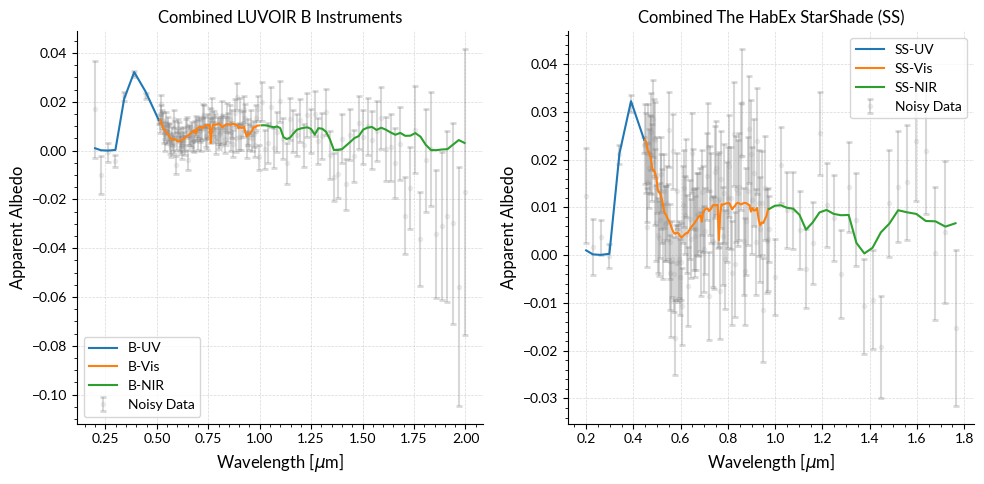

In [8]:
# Using our function...
dvis.plot_spectrum(df, index=np.random.randint(len(df)), noise=True);

In [9]:
def plothist(column, ylabel, nbins, ax, units="", decimal=0):
    data = df[column] 
    min_val = data.min()
    max_val = data.max()

    bin_edges = np.linspace(min_val, max_val, nbins + 1)

    hist = ax.hist(
        data,
        bins=bin_edges,
        histtype="step",
        edgecolor="k",
        lw=1,
    )
    
    ax.set_xlabel(ylabel)
    text = f"\n{min_val:.{decimal}f} to {max_val:.{decimal}f} {units}"

    if column == "OBJECT-STAR-TEMPERATURE":
        ax.text(
            0.03, 1, text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none')
            )
    else:
        ax.text(
            0.95, 1, text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none')
            )

    return hist, ax

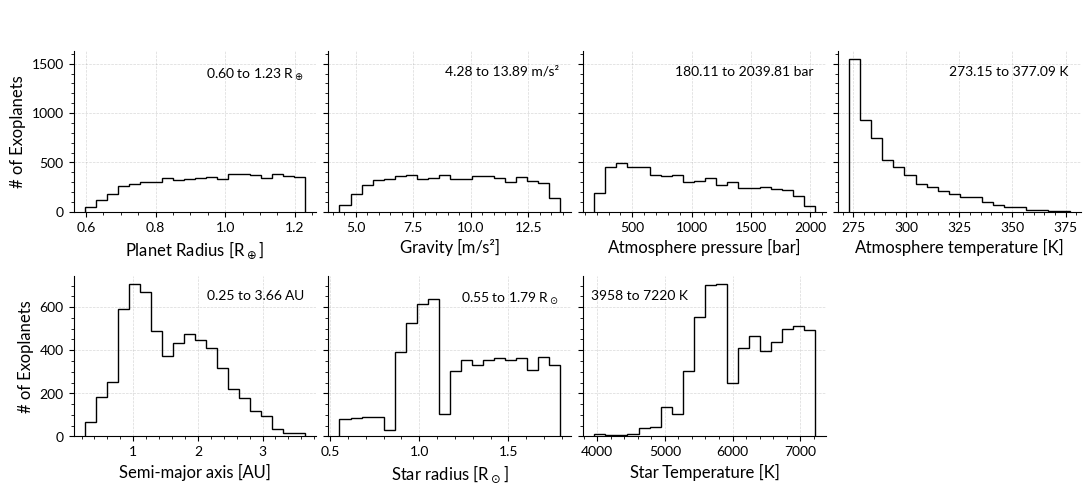

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(13, 5), sharey="row")
fig.subplots_adjust(hspace=0.4, wspace=0.05)

plothist("OBJECT-RADIUS-REL-EARTH", r"Planet Radius [R$_\oplus$]", 20, ax=ax[0, 0], units="R$_\oplus$", decimal=2)
plothist("OBJECT-GRAVITY", "Gravity [m/s²]", 20, ax=ax[0, 1], units="m/s²", decimal=2)
plothist("ATMOSPHERE-PRESSURE", "Atmosphere pressure [bar]", 20, ax=ax[0, 2], units="bar", decimal=2)
plothist("ATMOSPHERE-TEMPERATURE", "Atmosphere temperature [K]", 20, ax=ax[0, 3], units="K", decimal=2)
ax[0,0].set_ylabel("# of Exoplanets")
plothist("OBJECT-STAR-DISTANCE", "Semi-major axis [AU]", 20, ax=ax[1, 0], units="AU", decimal=2)
plothist("OBJECT-STAR-RADIUS", "Star radius [R$_\odot$]", 20, ax=ax[1, 1], units="R$_\odot$", decimal=2)
plothist("OBJECT-STAR-TEMPERATURE", "Star Temperature [K]", 20, ax=ax[1, 2], units="K", decimal=0)
ax[1,0].set_ylabel("# of Exoplanets")

fig.delaxes(ax[1][3])

handles, labels = ax[0, 0].get_legend_handles_labels()
labels = [label.title() for label in labels]
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.98), frameon=False, fontsize=12);

#plt.savefig("../images/parameters_distribution.pdf", bbox_inches='tight');

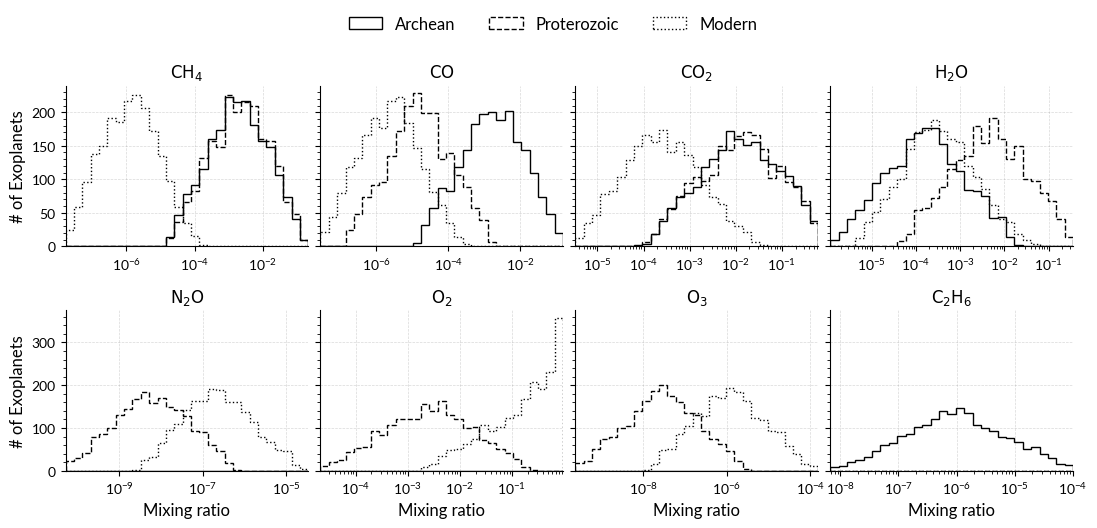

In [11]:
unique_molecules = ["CH4", "CO", "CO2", "H2O", "N2O", "O2", "O3", "C2H6"]
earth_types = ["archean", "proterozoic", "modern"]

fig, axes = plt.subplots(2, 4, figsize=(13, 5), sharey="row")
axes = np.atleast_2d(axes)
fig.subplots_adjust(hspace=0.4, wspace=0.05)

for row in range(2):
    axes[row, 0].set_ylabel("# of Exoplanets")

for col in [0, 1, 2, 3]:
    axes[-1, col].set_xlabel("Mixing ratio")

line_styles = ["solid", "dashed", "dotted"]

def format_molecule(molecule):
    formatted = molecule[0]
    for char in molecule[1:]:
        if char.isdigit():
            formatted += r"_{\mathrm{" + char + "}}"
        else:
            formatted += char
    return rf"\mathrm{{{formatted}}}"

for i, molecule in enumerate(unique_molecules):
    row, col = divmod(i, 4)
    ax = axes[row, col]

    data_list = []
    labels = []

    for j, earth_type in enumerate(earth_types):
        subset = df[(df["Earth_type"] == earth_type) & (df[molecule].notna())]
        if not subset.empty:
            data_list.append(subset[molecule])
            labels.append(earth_type)

    non_zero_data_list = [data[data > 0] for data in data_list]

    if any(len(d) > 0 for d in non_zero_data_list):
        bins = np.logspace(
            np.log10(min(d.min() for d in non_zero_data_list if len(d) > 0)),
            np.log10(max(d.max() for d in non_zero_data_list if len(d) > 0)),
            30
        )

        for j, data in enumerate(non_zero_data_list):
            ax.hist(
                data,
                bins=bins,
                histtype="step",
                linestyle=line_styles[j],
                color="black",
                label=labels[j],
                lw=1,
            )

        ax.set_xscale("log")
        ax.set_xlim(bins[0], bins[-1])

    ax.set_title(rf"${format_molecule(molecule)}$")

for j in range(len(unique_molecules), axes.size):
    fig.delaxes(axes.flatten()[j])

fig.legend(
    [f"{earth_type.title()}" for earth_type in earth_types],
    loc='upper center',
    ncol=len(earth_types),
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    fontsize=12
)

plt.show()

# plt.savefig("../images/mixingratio_distribution.pdf", bbox_inches='tight');

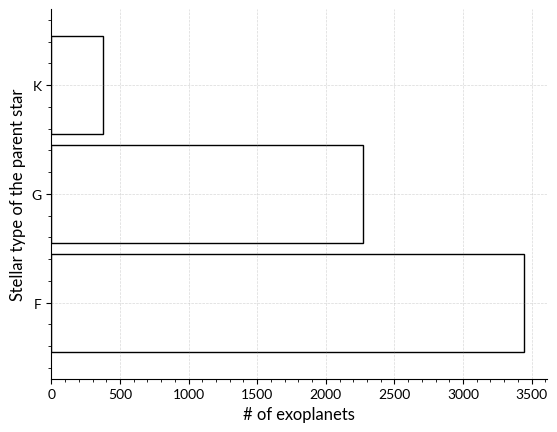

In [12]:
df["OBJECT-STAR-TYPE"].value_counts().plot(kind="barh", ec="k", width=0.9, color="none")
plt.xticks(rotation=0)
plt.ylabel("Stellar type of the parent star"), plt.xlabel("# of exoplanets");

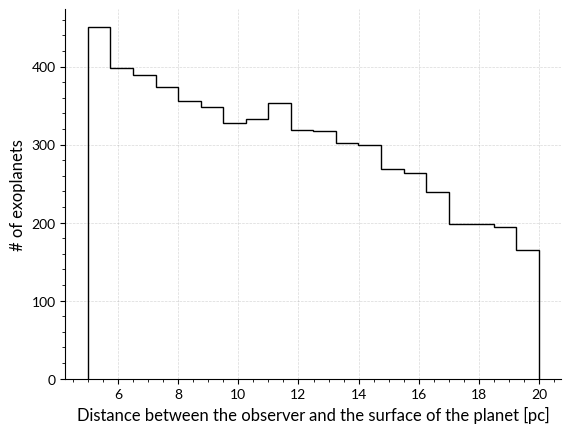

In [13]:
df["GEOMETRY-OBS-ALTITUDE"].hist(ec="k", bins=20, histtype="step")
plt.xlabel("Distance between the observer and the surface of the planet [pc]")
plt.ylabel("# of exoplanets");

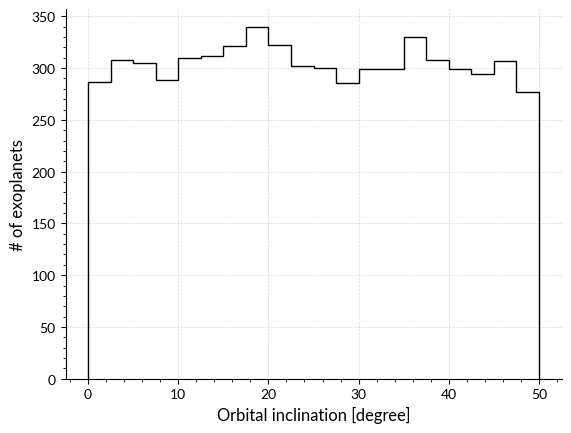

In [14]:
df["OBJECT-INCLINATION"].hist(ec="k", bins=20, histtype="step")
plt.xlabel("Orbital inclination [degree]")
plt.ylabel("# of exoplanets");

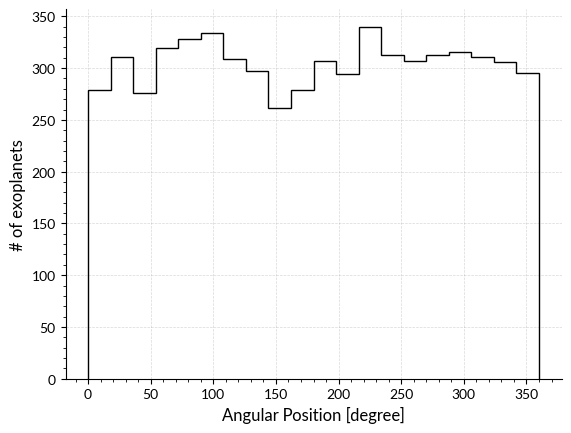

In [15]:
df["OBJECT-SEASON"].hist(ec="k", bins=20, histtype="step")
plt.xlabel("Angular Position [degree]")
plt.ylabel("# of exoplanets");

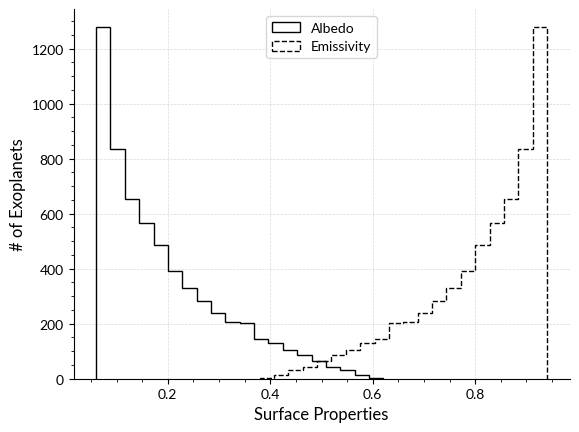

In [16]:
df["SURFACE-ALBEDO"].hist(linestyle="solid", color="k", bins=20, histtype="step", label="Albedo")
df["SURFACE-EMISSIVITY"].hist(linestyle="dashed", color="k", bins=20, histtype="step", label="Emissivity")
plt.xlabel("Surface Properties")
plt.ylabel("# of Exoplanets")
plt.legend();

# Analysis of noise influence

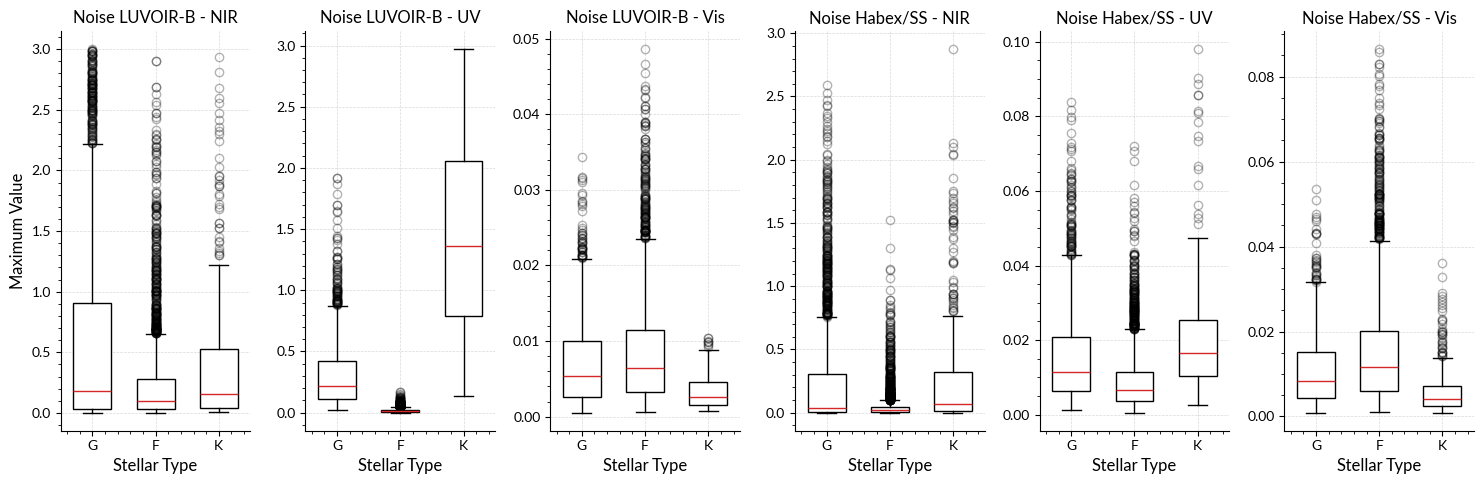

In [17]:
noise_columns = [col for col in df.columns if "NOISE_" in col]
data = df[noise_columns]

title_mapping = {
    "NOISE_": "Noise ",
    "B-": "LUVOIR-B - ",
    "SS-": "Habex/SS - "
}

max_values_df = pd.DataFrame({
    col: pd.Series(data[col].explode().astype(float).groupby(level=0).max())
    for col in data.columns
})

max_values_df["GEOMETRY-STELLAR-TYPE"] = df["GEOMETRY-STELLAR-TYPE"].values
stellar_types = max_values_df["GEOMETRY-STELLAR-TYPE"].unique()

plt.figure(figsize=(15, 5))
for i, col in enumerate(noise_columns):
    plt.subplot(1, len(noise_columns), i + 1)
    for j, stellar_type in enumerate(stellar_types):
        filtered_values = max_values_df[max_values_df["GEOMETRY-STELLAR-TYPE"] == stellar_type][col]
        bp = plt.boxplot(
            filtered_values.dropna(),
            positions=[j],
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor="white", color='k', linewidth=1),
            medianprops=dict(color='tab:red', linewidth=1),
            whiskerprops=dict(color='k', linewidth=1),
            capprops=dict(color='k', linewidth=1),
            flierprops=dict(marker='o', color="tab:gray", alpha=0.3)
        )

    formatted_title = col
    for key, value in title_mapping.items():
        formatted_title = formatted_title.replace(key, value)  # Apply replacements
    plt.gcf().axes[i].set_title(formatted_title)

    plt.xticks(range(len(stellar_types)), stellar_types)
    plt.xlabel("Stellar Type")
    plt.ylabel("Maximum Value")

for i, ax in enumerate(plt.gcf().axes):  
    if i > 0: 
        ax.set_ylabel('')

plt.tight_layout();

In [18]:
noise_ss_columns = [col for col in dfwithoutlimit.columns if "NOISE_SS" in col]
noise_b_columns = [col for col in dfwithoutlimit.columns if "NOISE_B" in col]

max_noise_values = np.logspace(np.log10(50), np.log10(0.01), 50)
extra_frames = 40 
max_noise_values = np.concatenate([max_noise_values, [max_noise_values[-1]] * extra_frames])

fig, ax = plt.subplots(figsize=(8, 5))
bins = 30 

def update(frame):
    ax.clear()
    max_noise = max_noise_values[frame]
    
    mask_ss = ~dfwithoutlimit[noise_ss_columns].applymap(lambda x: any(value > max_noise for value in x)).any(axis=1)
    filtered_dfwithoutlimit_ss = dfwithoutlimit[mask_ss]
    distances_ss = filtered_dfwithoutlimit_ss["GEOMETRY-OBS-ALTITUDE"]
    
    mask_b = ~dfwithoutlimit[noise_b_columns].applymap(lambda x: any(value > max_noise for value in x)).any(axis=1)
    filtered_dfwithoutlimit_b = dfwithoutlimit[mask_b]
    distances_b = filtered_dfwithoutlimit_b["GEOMETRY-OBS-ALTITUDE"]
    
    ax.hist(distances_ss, bins=bins, histtype="step", color="k", linestyle='solid', label="Habex/SS")
    ax.hist(distances_b, bins=bins, histtype="step", color="k", linestyle='dashed', label="LUVOIR B")

    ax.set_title(f"Max Noise: {max_noise:.2f}")
    ax.set_xlabel("Distance between observer and surface of planet [pc]")
    ax.set_ylabel("# of exoplanets")
    ax.set_xlim(dfwithoutlimit["GEOMETRY-OBS-ALTITUDE"].min(), dfwithoutlimit["GEOMETRY-OBS-ALTITUDE"].max())
    ax.legend()

ani = animation.FuncAnimation(fig, update, frames=len(max_noise_values), repeat=False)
ani.save("../images/noise_mask_influence.gif", writer=PillowWriter(fps=5))
plt.close()

# Data distribution (paper tables)

In [19]:
known_feature_description = {
    "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
    "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
    "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
    "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

    'Earth_type': tf.io.FixedLenFeature([], tf.string),

    'C2H6': tf.io.FixedLenFeature([], tf.float32),
    'CH4': tf.io.FixedLenFeature([], tf.float32),
    'CO': tf.io.FixedLenFeature([], tf.float32),
    'CO2': tf.io.FixedLenFeature([], tf.float32),
    'H2O': tf.io.FixedLenFeature([], tf.float32),
    'N2': tf.io.FixedLenFeature([], tf.float32),
    'N2O': tf.io.FixedLenFeature([], tf.float32),
    'O2': tf.io.FixedLenFeature([], tf.float32),
    'O3': tf.io.FixedLenFeature([], tf.float32)
}

def parse_example(example_proto, feature_description):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    dense_features = {
        key: tf.sparse.to_dense(value, default_value=0.0)
        if isinstance(value, tf.SparseTensor) else value
        for key, value in parsed_features.items()
    }
    return dense_features

tfrecord_file = "../data/all_samples.tfrecord"
dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = dataset.map(lambda x: parse_example(x, known_feature_description))

In [30]:
# Define the features of interest
features_to_extract = [
    "OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY", 
    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE",
    "C2H6", "CH4", "CO", "CO2", 
    "H2O", "N2", "N2O", "O2", "O3"
]

earth_types = ["archean", "proterozoic", "modern"]

feature_stats = {
    et: {key: {"min": float("inf"), "max": float("-inf")} for key in features_to_extract}
    for et in earth_types
}

for sample in parsed_dataset:
    earth_type = sample["Earth_type"].numpy().decode("utf-8") 
    if earth_type in earth_types:
        for key in features_to_extract:
            value = sample[key].numpy()
            feature_stats[earth_type][key]["min"] = min(feature_stats[earth_type][key]["min"], value)
            feature_stats[earth_type][key]["max"] = max(feature_stats[earth_type][key]["max"], value)

In [31]:
data = []
for et, stats in feature_stats.items():
    for feature, values in stats.items():
        data.append({
            "Earth Type": et,
            "Feature": feature,
            "Min": values["min"],
            "Max": values["max"]
        })

df = pd.DataFrame(data)

for i in df["Earth Type"].unique():
    print(f">> {i.upper()}")
    display(df[df["Earth Type"] == i][["Feature", "Min", "Max"]])

>> ARCHEAN


,Feature,Min,Max
0,OBJECT-RADIUS-REL-EARTH,5.846455e-01,1.229999
1,OBJECT-GRAVITY,4.223542e+00,13.933218
2,ATMOSPHERE-TEMPERATURE,2.731500e+02,382.165741
3,ATMOSPHERE-PRESSURE,1.665834e+02,2046.163452
4,C2H6,6.529010e-09,0.000128
5,CH4,1.338738e-05,0.209064
6,CO,1.101223e-05,0.182645
7,CO2,8.688415e-05,0.647208
8,H2O,1.111052e-06,0.022886
9,N2,3.058093e-01,0.999860


>> PROTEROZOIC


,Feature,Min,Max
13,OBJECT-RADIUS-REL-EARTH,5.838501e-01,1.229999e+00
14,OBJECT-GRAVITY,4.208384e+00,1.393667e+01
15,ATMOSPHERE-TEMPERATURE,2.731501e+02,3.830920e+02
16,ATMOSPHERE-PRESSURE,1.649131e+02,2.044752e+03
17,C2H6,0.000000e+00,0.000000e+00
18,CH4,1.491523e-05,2.338403e-01
19,CO,1.188962e-07,2.327753e-03
20,CO2,8.672331e-05,6.424711e-01
21,H2O,3.208837e-05,3.860236e-01
22,N2,2.623143e-01,9.998103e-01


>> MODERN


,Feature,Min,Max
26,OBJECT-RADIUS-REL-EARTH,5.808369e-01,1.230000
27,OBJECT-GRAVITY,4.226868e+00,13.940492
28,ATMOSPHERE-TEMPERATURE,2.731501e+02,383.379700
29,ATMOSPHERE-PRESSURE,1.716080e+02,2046.656372
30,C2H6,0.000000e+00,0.000000
31,CH4,1.220383e-08,0.000243
32,CO,2.238285e-08,0.000441
33,CO2,2.702974e-06,0.048904
34,H2O,3.322644e-06,0.062391
35,N2,2.509525e-02,0.998131


# How many planets can retain atmospheres?

In [ ]:
spectral_type = ['F', 'G', 'K']
params = {
    'F': {'temp_range': (6000, 7220), 'radius_range': (1.18, 1.79), 'mag_range': (2.50, 4.22)},
    'G': {'temp_range': (5340, 5920), 'radius_range': (0.876, 1.12), 'mag_range': (4.40, 5.34)},
    'K': {'temp_range': (3940, 5280), 'radius_range': (0.552, 0.817), 'mag_range': (5.54, 7.59)},
}

def simulate_planet():
    class_star = np.random.choice(spectral_type)
    star_temperature = round(np.random.uniform(*params[class_star]['temp_range']), 3)
    star_radius = round(np.random.uniform(*params[class_star]['radius_range']), 3)

    temp = star_temperature - 5780
    star_luminosity = 4 * np.pi * (star_radius * R_sun.value) ** 2 * sigma_sb.value * star_temperature ** 4

    S_eff_odot = 1.776
    a, b, c, d = 2.136e-4, 2.533e-8, -1.332e-11, -3.097e-15
    S_eff_lower = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4

    S_eff_odot = 0.32
    a, b, c, d = 5.547e-5, 1.526e-9, -2.874e-12, -5.011e-16
    S_eff_upper = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4
    lower_dist = np.sqrt((star_luminosity / L_sun.value) / S_eff_lower)
    upper_dist = np.sqrt((star_luminosity / L_sun.value) / S_eff_upper)
    semi_major_axis = np.random.uniform(lower_dist, upper_dist)

    planet_radius = np.random.uniform(0.3, 1.23)
    planet_mass = planet_radius ** (1 / (0.279 + np.random.uniform(-0.009, 0.009)))
    gravity = G.value * (planet_mass * M_earth.value) / (planet_radius * R_earth.value) ** 2
    escape_velocity = np.sqrt(2 * gravity * planet_radius * R_earth.value)

    real_insolation = (1 ** 2 / semi_major_axis ** 2) * (star_luminosity / L_sun.value)
    cosmic_shoreline = (5 * 1e-16) * (escape_velocity) ** 4

    return real_insolation < cosmic_shoreline

def run_simulations(n=100000):
    count_atmosphere = 0
    count_no_atmosphere = 0

    for _ in range(n):
        if simulate_planet():
            count_atmosphere += 1
        else:
            count_no_atmosphere += 1

    return count_atmosphere, count_no_atmosphere

count_atmosphere, count_no_atmosphere = run_simulations()
print(f"Planets with atmosphere: {count_atmosphere} ({(count_atmosphere / 100000) * 100:.2f}%)")
print(f"Planets without atmosphere: {count_no_atmosphere} ({(count_no_atmosphere / 100000) * 100:.2f}%)")

Planets with atmosphere: 65625 (65.62%)
Planets without atmosphere: 34375 (34.38%)


In [ ]:
def calculate_boiling_point(pressure_mbar):
    P0 = 1013.25  # Reference pressure (1 atm in mbar)
    T0 = 373.15  # Boiling point of water at 1 atm (in K)
    Hv = 40.65*1e3  # Latent heat of vaporization (in J/mol)
    return 1 / ((1 / T0) - (R.value / Hv) * np.log(pressure_mbar / P0))

def simulate_planet():
    spectral_type = ['F', 'G', 'K']
    class_star = np.random.choice(spectral_type)

    params = {
        'F': {'temp_range': (6000, 7220), 'radius_range': (1.18, 1.79), 'mag_range': (2.50, 4.22)},
        'G': {'temp_range': (5340, 5920), 'radius_range': (0.876, 1.12), 'mag_range': (4.40, 5.34)},
        'K': {'temp_range': (3940, 5280), 'radius_range': (0.552, 0.817), 'mag_range': (5.54, 7.59)},
    }

    star_temperature = round(np.random.uniform(*params[class_star]['temp_range']), 3)
    star_radius = round(np.random.uniform(*params[class_star]['radius_range']), 3)
    star_luminosity = 4 * np.pi * (star_radius * R_sun.value) ** 2 * sigma_sb.value * star_temperature ** 4

    temp = star_temperature - 5780

    # Recent Venus (lower limit)
    S_eff_odot = 1.776
    a, b, c, d = 2.136e-4, 2.533e-8, -1.332e-11, -3.097e-15
    S_eff_lower = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4

    # Early Mars (upper limit)
    S_eff_odot = 0.32
    a, b, c, d = 5.547e-5, 1.526e-9, -2.874e-12, -5.011e-16
    S_eff_upper = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4

    # Distance of the habitable zone
    lower_dist = np.sqrt((star_luminosity / L_sun.value) / S_eff_lower)
    upper_dist = np.sqrt((star_luminosity / L_sun.value) / S_eff_upper)
    semi_major_axis = np.random.uniform(lower_dist, upper_dist)

    # Planet properties
    planet_radius = np.random.uniform(0.3, 1.23)
    planet_mass = planet_radius ** (1 / (0.279 + np.random.uniform(-0.009, 0.009)))
    gravity = G.value * (planet_mass * M_earth.value) / (planet_radius * R_earth.value) ** 2
    escape_velocity = np.sqrt(2 * gravity * planet_radius * R_earth.value)
    real_insolation = (1 ** 2 / semi_major_axis ** 2) * (star_luminosity / L_sun.value)
    cosmic_shoreline = (5 * 1e-16) * (escape_velocity) ** 4

    if real_insolation < cosmic_shoreline:
        # Atmosphere and temperature
        albedo = np.random.uniform(0.06, 0.96)
        emissivity = 1 - albedo
        pressure_mbar = 1013.25 * (planet_radius ** (3.168 + np.random.uniform(-0.232, 0.232)))
        teq = ((1 - albedo) * (real_insolation * 1361.0) / (4 * sigma_sb.value)) ** (1 / 4)
        temperature_analogue = teq * (2 / (2 - emissivity)) ** (1 / 4)

        boiling_point = calculate_boiling_point(pressure_mbar)
        freezing_point = 273.15 if pressure_mbar * 100 > 611.657 else None

        if freezing_point is None:
            return "Water sublimates (solid state to gaseous state)"

        if freezing_point and freezing_point <= temperature_analogue <= boiling_point:
            return "Planet supports liquid water."
        elif temperature_analogue > boiling_point:
            return "The planet is boiling!"
        elif temperature_analogue < 273.15:
            return "THe planet is freezing!"
    else:
        return "Planet cannot retain atmosphere."

results = {
    "Water sublimates (solid state to gaseous state)": 0,
    "Planet supports liquid water.": 0,
    "The planet is boiling!": 0,
    "THe planet is freezing!": 0,
    "Planet cannot retain atmosphere.": 0
}

for _ in range(100000):
    outcome = simulate_planet()
    if outcome in results:
        results[outcome] += 1

# Calculate percentages
total = sum(results.values())
percentages = {key: (value / total) * 100 for key, value in results.items()}
{key: f"{value} ({percentages[key]:.2f}%)" for key, value in results.items()}

{'Water sublimates (solid state to gaseous state)': '0 (0.00%)',
 'Planet supports liquid water.': '9874 (9.87%)',
 'The planet is boiling!': '80 (0.08%)',
 'THe planet is freezing!': '55450 (55.45%)',
 'Planet cannot retain atmosphere.': '34596 (34.60%)'}

In [ ]:
# Total with atmosphere
9874 + 80 + 55450

65404

In [ ]:
# With liquid water
9874 / 65404

0.1509693596721913

# Count the final samples

In [ ]:
import os

folder_path = '../data/TFRecord_data'
total_sum = 0

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Remove any file extension (if present)
        base_name = os.path.splitext(filename)[0]
        parts = base_name.split('_')
        if parts:  # Ensure there's at least one part
            try:
                # Convert the last part to an integer and add it to the total
                number = int(parts[-1])
                total_sum += number
            except ValueError:
                print(f"Skipping file '{filename}': '{parts[-1]}' is not an integer.")

print("Total sum:", total_sum)

Total sum: 1086914
